In [1]:
# LendingClub Data Statistical Analysis
# Two sources of data and a data dictionary
# Data in CSV and SQL files are provided - Kaggle
# Looks like FICO score data is missing and some column names are different
import math
import sqlite3
import csv
import pandas as pd
import collections
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dateutil.parser import parse
from datetime import datetime
from statsmodels.stats import weightstats as stests
from scipy.stats import ks_2samp

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

dataURL = 'https://www.kaggle.com/wendykan/lending-club-loan-data/downloads/lending-club-loan-data.zip'
homeDir = "/fdata/LendingClub/lending-club-loan-data/"
fnSQL = "database.sqlite"
fnCSV = "loan.csv"

# list of sub grade categories
sg = ['A1','A2','A3','A4','A5',\
      'B1','B2','B3','B4','B5',\
      'C1','C2','C3','C4','C5',\
      'D1','D2','D3','D4','D5',\
      'E1','E3','E3','E4','E5',\
      'F1','F2','F3','F4','F5',\
      'G1','G2','G3','G4','G5']

# read in column names from loan.csv
with open(homeDir+fnCSV) as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    cnCSV = next(reader)[0].split(',')
#print(len(cnCSV))
#print(cnCSV)
# 74 Data Columns

# get column of data from CSV file
def getCSVColumn(header):
    try:
        indx = cnCSV.index(header)
        with open(homeDir+fnCSV) as csvfile:
            reader = csv.reader(csvfile)
            tcol = list(zip(*reader))[indx]
            col = list(tcol)
            col.pop(0)
            return col
    except ValueError:
        print("Column not found:", header)
        col = []
        return col

# get column of data from SQLite file
def getSQLiteColumn(header):
    col = []
    conn = sqlite3.connect(homeDir+fnSQL)
    cursor = conn.execute('SELECT ' + header + ' FROM loan')
    for row in cursor.fetchall():
        col.append(row[0])
    return col

# statistical KS comparison of factor across sub grades
# test distributions are the same of factor in columns 10 sub-grade (2 grades) apart
def slidingKSTest(subgrade, factor, space):
    p = np.zeros(shape=(35 - space))
    for i in range(35 - space):
        s1 = sg[i]
        s2 = sg[i+space]
        t1 = []
        t2 = []
        for indx, entry in enumerate(subgrade):
            if entry == s1:
                if not math.isnan(factor[indx]):
                    t1.append(factor[indx])
            if entry == s2:
                if not math.isnan(factor[indx]):
                    t2.append(factor[indx])
        #print(len(t1),len(t2))
        a, b = ks_2samp(t1,t2)
        p[i] = b
    return p

# Statistical KS comparison between A grade and factor from all other sub-grades
# test 'distributions are the same'
def slidingAGrade_KSTest(subgrade, factor):
    p = np.zeros(shape=(30))
    for i in range(30):
        s1 = 'A'
        s2 = sg[i+5]
        t1 = []
        t2 = []
        for indx, entry in enumerate(subgrade):
            if entry[0:1] == s1:
                if not math.isnan(factor[indx]):
                    t1.append(factor[indx])
            if entry == s2:
                if not math.isnan(factor[indx]):
                    t2.append(factor[indx])
        #print(len(t1),len(t2))
        a, b = ks_2samp(t1,t2)
        p[i] = b
    return p

# Compare default/charge off to paid off
def compareGB(subgrade, status, factor,fname):
    fg = []
    sgg = []
    fb = []
    sgb = []
    for indx, entry in enumerate(status):
        if (entry == 'Fully Paid'):
            if not math.isnan(factor[indx]):
                fg.append(factor[indx])
                sgg.append(subgrade[indx]+'G')
        elif ((entry == 'Charged Off') | (entry == 'Default')):
            if not math.isnan(factor[indx]):
                fb.append(factor[indx])
                sgb.append(subgrade[indx]+'B')         
    gdf = pd.DataFrame(list(zip(sgg,fg)),columns=['Sub Grade',fname])
    bdf = pd.DataFrame(list(zip(sgb,fb)),columns=['Sub Grade',fname])
    return gdf, bdf

# Compare Bad/Good Loans using KS test
# each subgrade
# each total population
def GBKSTest(subgrade, status,factor,fname):
    good, bad = compareGB(subgrade,status,factor,fname)
    KSs = []
    for indx, entry in enumerate(sg):
        gn = good.loc[good['Sub Grade'] == entry+'G'][fname].tolist()
        bn =  bad.loc[bad['Sub Grade'] == entry+'B'][fname].tolist()
        a, b = ks_2samp(gn,bn)
        KSs.append(b)
    gna = good[fname].tolist()
    bna = bad[fname].tolist()
    a, KSa = ks_2samp(gna,bna)
    return KSs, KSa

In [2]:
# Load in processed LoanClubData
processed = pd.read_pickle(homeDir+'processed.pkl')
# do final clean up of data
#Add loan status column
lstat = getCSVColumn('loan_status')
lstat_s = pd.Series(lstat)
processed['Loan Status'] = lstat_s
processed.sort_values('Sub Grade',inplace=True)
processed['Debt Income Ratio'] =  processed['Debt Income Ratio'].apply(pd.to_numeric, errors='coerce')
processed['Debt Income Ratio - Joint'] =  processed['Debt Income Ratio - Joint'].apply(pd.to_numeric, errors='coerce')
processed['Annual Income'] =  processed['Annual Income'].apply(pd.to_numeric, errors='coerce')
processed['Annual Income - Joint'] =  processed['Annual Income - Joint'].apply(pd.to_numeric, errors='coerce')
processed['All Credit Ratio'] =  processed['All Credit Ratio'].apply(pd.to_numeric, errors='coerce')
processed['Current Deliquent Accounts'] =  processed['Current Deliquent Accounts'].apply(pd.to_numeric, errors='coerce')
processed['Collections (12mths)'] =  processed['Collections (12mths)'].apply(pd.to_numeric, errors='coerce')
processed['Delquient (2yrs)'] =  processed['Delquient (2yrs)'].apply(pd.to_numeric, errors='coerce')
processed['Personal Finance Inq'] =  processed['Personal Finance Inq'].apply(pd.to_numeric, errors='coerce')
processed['Credt Inq 12mts'] =  processed['Credt Inq 12mts'].apply(pd.to_numeric, errors='coerce')
processed['Revolving Credit Balance'] =  processed['Revolving Credit Balance'].apply(pd.to_numeric, errors='coerce')
processed['Revolving Credit Ratio'] =  processed['Revolving Credit Ratio'].apply(pd.to_numeric, errors='coerce')
print(processed.count())

Sub Grade                      887379
Loan Amount                    887379
Interest Rage                  887379
Annual Income                  887375
Annual Income - Joint             511
Income Verification            887379
Income Verification - Joint    887379
Data Issued                    887379
Debt Income Ratio              887379
Debt Income Ratio - Joint         509
Revolving Credit Balance       887379
Revolving Credit Ratio         886877
All Credit Ratio                21372
Current Deliquent Accounts     887379
Collections (12mths)           887379
Delquient (2yrs)               887379
Years Employed                 887379
Home Ownership                 887379
Inquiries (6mths)              887379
Personal Finance Inq           887379
Credt Inq 12mts                 17389
Inst Credit Ratio              887379
Earliest Credit                887379
Max Bal Revol                   21372
Total Coll E Owed              817103
Mths Last Delq                 433067
Mths Last De

In [3]:
# save final data
processed.to_pickle(homeDir+'processed_final.pkl')

In [4]:
processed = pd.read_pickle(homeDir+'processed_final.pkl')
processed = processed.rename(columns={'Interest Rage':'Interest Rate'})
print(processed.count())
ulist = ['Income Verification','Debt Income Ratio','Revolving Credit Balance','Current Deliquent Accounts'\
         ,'Collections (12mths)','Delquient (2yrs)','Years Employed','Inquiries (6mths)','Personal Finance Inq'\
         ,'Inst Credit Ratio','Earliest Credit','Annual Income','Revolving Credit Balance ','Num Open Acc']

Sub Grade                      887379
Loan Amount                    887379
Interest Rate                  887379
Annual Income                  887375
Annual Income - Joint             511
Income Verification            887379
Income Verification - Joint    887379
Data Issued                    887379
Debt Income Ratio              887379
Debt Income Ratio - Joint         509
Revolving Credit Balance       887379
Revolving Credit Ratio         886877
All Credit Ratio                21372
Current Deliquent Accounts     887379
Collections (12mths)           887379
Delquient (2yrs)               887379
Years Employed                 887379
Home Ownership                 887379
Inquiries (6mths)              887379
Personal Finance Inq           887379
Credt Inq 12mts                 17389
Inst Credit Ratio              887379
Earliest Credit                887379
Max Bal Revol                   21372
Total Coll E Owed              817103
Mths Last Delq                 433067
Mths Last De

/usr/lib/python3/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


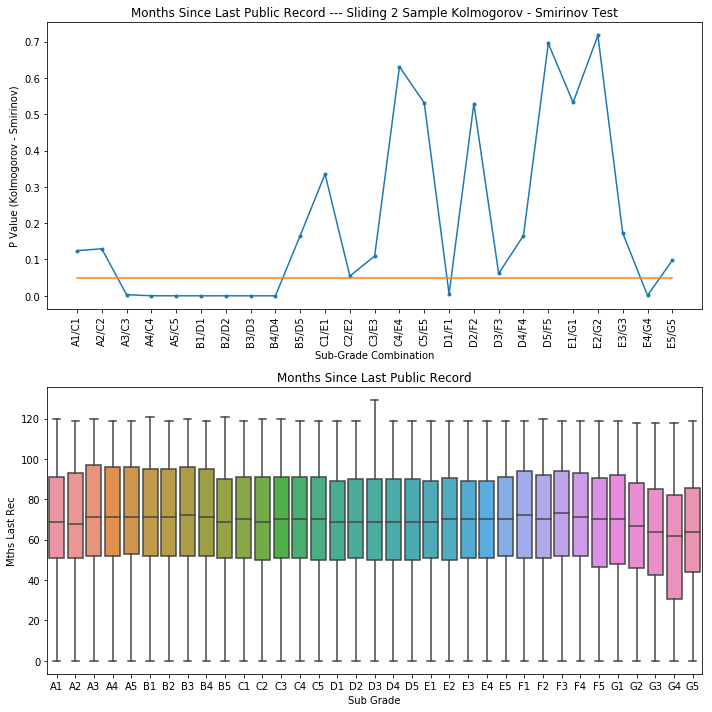

In [5]:
col = 'Mths Last Rec'
nam = 'Months Since Last Public Record'
labels = ['A1/C1','A2/C2','A3/C3','A4/C4','A5/C5',\
          'B1/D1','B2/D2','B3/D3','B4/D4','B5/D5',\
          'C1/E1','C2/E2','C3/E3','C4/E4','C5/E5',\
          'D1/F1','D2/F2','D3/F3','D4/F4','D5/F5',\
          'E1/G1','E2/G2','E3/G3','E4/G4','E5/G5']
labels_5 = ['A1/B1','A2/B2','A3/B3','A4/B4','A5/B5',\
            'B1/C1','B2/C2','B3/C3','B4/D4','B5/C5',\
            'C1/D1','C2/D2','C3/D3','C4/D4','C5/D5',\
            'D1/E1','D2/E2','D3/E3','D4/E4','D5/E5',\
            'E1/F1','E2/F2','E3/F3','E4/F4','E5/F5',\
            'F1/G1','F2/G2','F3/G3','F4/G4','F5/G5']

sgrade = list(processed['Sub Grade'])
fac = list(processed[col])
p1 = slidingKSTest(sgrade, fac, 10)
#print(p1)

fig, (ax1 , ax2) = plt.subplots(2,1)
fig.set_size_inches(10, 10)
#fig.tight_layout()
plt.subplots_adjust(hspace=0.25)
ax1.plot(p1,marker='.')
ax1.plot([0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,\
          0.05,0.05,0.05,0.05,0.05,0.05,0.05])
ax1.margins(0.05)
ax1.set_xticks(np.arange(0, 25, 1.0))
ax1.set_xticklabels(labels,rotation=90)
ax1.set_xlabel('Sub-Grade Combination')
ax1.set_ylabel('P Value (Kolmogorov - Smirinov)')
ax1.set_title(nam+' --- Sliding 2 Sample Kolmogorov - Smirinov Test')
sns.boxplot(x='Sub Grade',y=col,data=processed)
ax2.set_title(nam)
#ax2.set_ylim([0,300000])
plt.show()
fig.savefig(homeDir+'images/'+nam.replace(' ','')+'.png')

/usr/lib/python3/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


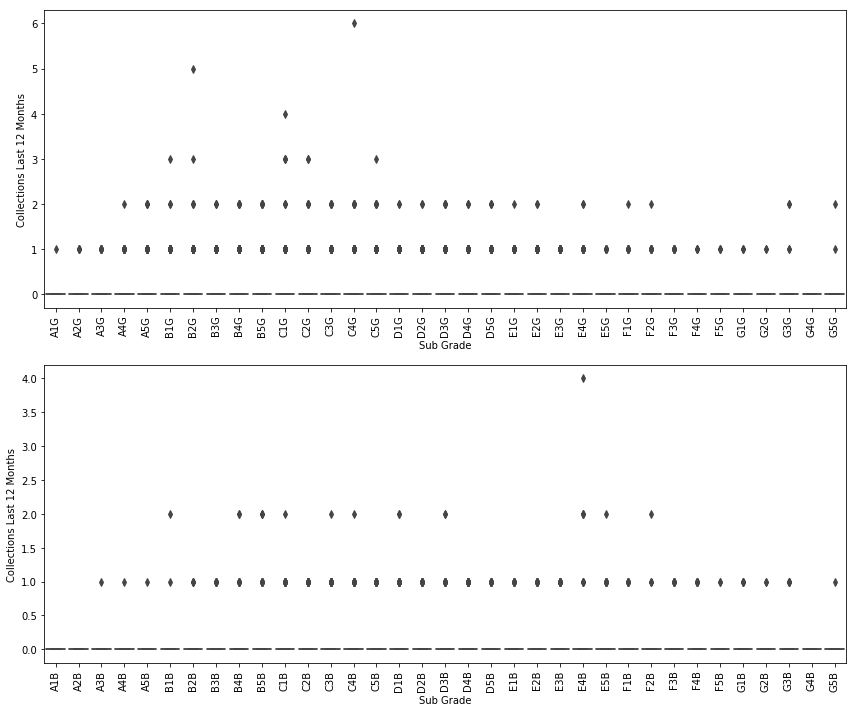

In [6]:
col = 'Collections (12mths)'
nam = 'Collections Last 12 Months'
sgrade = list(processed['Sub Grade'])
stat = list(processed['Loan Status'])
fac = list(processed[col])
good, bad = compareGB(sgrade, stat, fac, nam)
fig, (ax1 , ax2) = plt.subplots(2,1)
fig.set_size_inches(12, 10)
plt.sca(ax1)
plt.xticks(rotation=90)
sns.boxplot(x='Sub Grade',y=nam,data=good,ax = ax1)
plt.sca(ax2)
plt.xticks(rotation=90)
sns.boxplot(x='Sub Grade',y=nam,data=bad,ax = ax2)
plt.show()

/usr/lib/python3/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


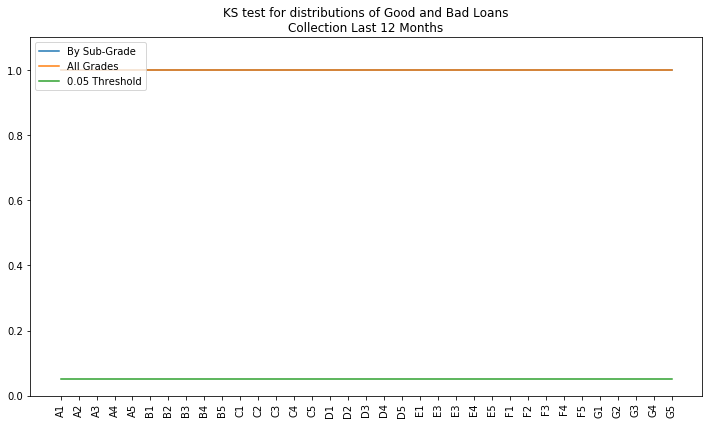

In [7]:
#Split by good bad
col = 'Collections (12mths)'
nam = 'Collection Last 12 Months'
sgrade = list(processed['Sub Grade'])
stat = list(processed['Loan Status'])
fac = list(processed[col])
kss, ksa = GBKSTest(sgrade, stat, fac, nam)
#print(kss)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 6)
plt.plot(kss,label='By Sub-Grade')
ka = [ksa for number in range(35)]
thresh = [0.05 for number in range(35)]
plt.plot(ka,label='All Grades')
plt.title("KS test for distributions of Good and Bad Loans\n"+nam)
plt.plot(thresh,label='0.05 Threshold')
ax.set_xticks(np.arange(0, 35, 1.0))
ax.set_xticklabels(sg,rotation=90)
plt.ylim([0,1.1])
ax.margins(0.05)
ax.legend(loc=2)
plt.show()

In [32]:
ulist = ['Loan Status','Income Verification','Debt Income Ratio','Revolving Credit Balance','Current Deliquent Accounts'\
         ,'Collections (12mths)','Delquient (2yrs)','Years Employed','Inquiries (6mths)','Personal Finance Inq'\
         ,'Inst Credit Ratio','Earliest Credit','Annual Income','Revolving Credit Ratio','Num Open Acc','Total Coll E Owed']
fData = processed[ulist]

# Income Verification to numeric
fData.loc[fData['Income Verification'] == 'Not Verified', 'IVCode'] = 0
fData.loc[fData['Income Verification'] == 'Source Verified', 'IVCode'] = 1
fData.loc[fData['Income Verification'] == 'Verified', 'IVCode'] = 2
# Loan Status to numeric
# Only use default, charged off (bad) and fully paid (good)
fData.loc[(fData['Loan Status'] == 'Fully Paid') | \
          (fData['Loan Status'] == 'Does not meet the credit policy. Status:Fully Paid'),'LSCode'] = 0
fData.loc[(fData['Loan Status'] == 'Charged Off') | (fData['Loan Status'] == 'Default') | \
          (fData['Loan Status'] == 'Does not meet the credit policy. Status:Charged Off')] = 1
# save version before NaNs dropped
fData1 = fData
# Drop all NaN
fData.dropna(inplace=True)
# Delete Income Verification and Load Status
del fData['Income Verification']
del fData['Loan Status']
print(fData.count())
#pickle fData
fData.to_pickle(homeDir+'finalData.pkl')

/usr/lib/python3/dist-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/lib/python3/dist-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Debt Income Ratio             201165
Revolving Credit Balance      201165
Current Deliquent Accounts    201165
Collections (12mths)          201165
Delquient (2yrs)              201165
Years Employed                201165
Inquiries (6mths)             201165
Personal Finance Inq          201165
Inst Credit Ratio             201165
Earliest Credit               201165
Annual Income                 201165
Revolving Credit Ratio        201165
Num Open Acc                  201165
Total Coll E Owed             201165
IVCode                        201165
LSCode                        201165
dtype: int64


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Accuracy Score on Train Data:  0.999946975271
Accuracy Score on Test Data:  1.0
[[38431     0]
 [    0 11861]]
[[115498      8]
 [     0  35367]]
Average Precision Score:  1.0


/usr/lib/python3/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


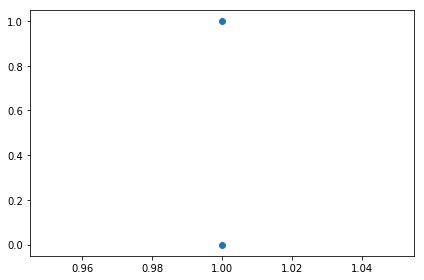

In [33]:
# unpickle data
fData = pd.read_pickle(homeDir+'finalData.pkl')
# import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Create data and classification sets
fnames = ['Debt Income Ratio',\
             'Revolving Credit Balance',\
             'Current Deliquent Accounts',\
             'Collections (12mths)',\
             'Delquient (2yrs)',\
             'Years Employed',\
             'Inquiries (6mths)',\
             'Personal Finance Inq',\
             'Inst Credit Ratio',\
             'Earliest Credit',\
             'Annual Income',\
             'Revolving Credit Ratio',\
             'Num Open Acc',\
             'Total Coll E Owed',\
             'IVCode']

dfX = fData[fnames]
y = np.array(fData['LSCode'])
# scale data
X = StandardScaler().fit_transform(dfX)
# create training and testing data sets
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=133)
# setup grid search
Cs = [0.001, 0.01, 0.1 ,1, 10]
gammas = [0.001, 0.01,0.1, 1]
param_grid = {'C':Cs,'gamma':gammas}
grid_search = GridSearchCV(svm.SVC(kernel='linear'),param_grid,cv=10)
# Train SVC classifier
grid_search.fit(X_train,y_train)
grid_search.best_params_
# use best params
p = list(grid_search.best_params_.values())
clf = svm.SVC(kernel='linear',gamma = p[1],C=p[0])
clf.fit(X_train,y_train)
# get prediction for test and train data
predict1 = clf.predict(X_test)
predict2 = clf.predict(X_train)
# accuracy scores for test and train data
print("Accuracy Score on Train Data: ",accuracy_score(y_train,predict2))
print("Accuracy Score on Test Data: ",accuracy_score(y_test,predict1))
# confusion matricies for test and train data
print(confusion_matrix(y_test,predict1))
print(confusion_matrix(y_train,predict2))
# precision recall plot
y_score = clf.decision_function(X_test)
avgpre = average_precision_score(y_test,y_score)
print('Average Precision Score: ',avgpre)
precision, recall, thresholds = precision_recall_curve(y_test,y_score)
plt.step(precision,recall,linewidth=0,marker='o')
plt.show()

/usr/lib/python3/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


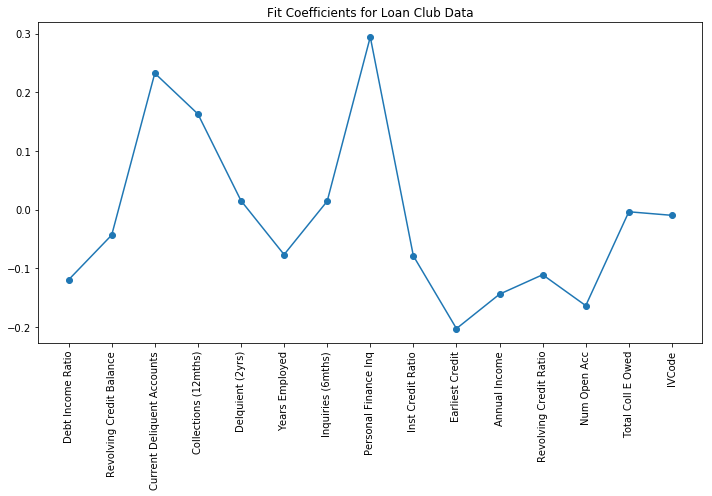

In [34]:
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(10, 7)
ax1.margins(0.05)
ax1.set_xticks(np.arange(0, 15, 1.0))
ax1.set_xticklabels(fnames,rotation=90)
plt.title('Fit Coefficients for Loan Club Data')
plt.plot(clf.coef_.tolist()[0],marker='o')
plt.show()

/usr/lib/python3/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


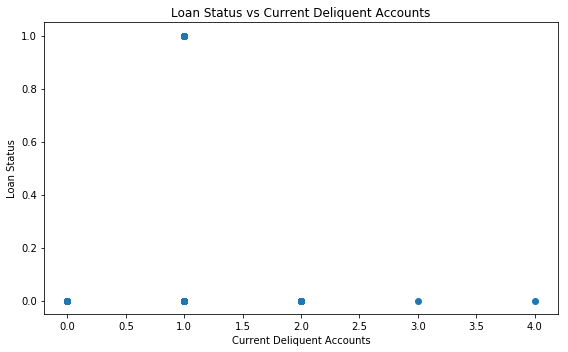

In [35]:
x = np.array(fData['Current Deliquent Accounts'])
y = np.array(fData['LSCode'])
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8, 5)
plt.plot(x[:175000],y[:175000],marker='o',linewidth=0.0)
plt.xlabel('Current Deliquent Accounts')
plt.ylabel('Loan Status')
plt.title('Loan Status vs Current Deliquent Accounts')
plt.show()

In [36]:
# calculate the variance of all columns in both good and bad data sets
bad_01 = fData[fData['LSCode']==1]
good_01 = fData[fData['LSCode']==0]
bvar = bad_01.var(axis=0)
gvar = good_01.var(axis=0)
print(bvar,gvar)

Debt Income Ratio             0.0
Revolving Credit Balance      0.0
Current Deliquent Accounts    0.0
Collections (12mths)          0.0
Delquient (2yrs)              0.0
Years Employed                0.0
Inquiries (6mths)             0.0
Personal Finance Inq          0.0
Inst Credit Ratio             0.0
Earliest Credit               0.0
Annual Income                 0.0
Revolving Credit Ratio        0.0
Num Open Acc                  0.0
Total Coll E Owed             0.0
IVCode                        0.0
LSCode                        0.0
dtype: float64 Debt Income Ratio             6.081339e+01
Revolving Credit Balance      4.101893e+08
Current Deliquent Accounts    4.544634e-03
Collections (12mths)          1.034459e-02
Delquient (2yrs)              6.226807e-01
Years Employed                1.492368e+01
Inquiries (6mths)             1.123380e+00
Personal Finance Inq          4.461511e-03
Inst Credit Ratio             4.869610e+00
Earliest Credit               6.572376e+06
Annual Inco

In [44]:
# look at some of the columns that have 21372 entries
check = processed[['Loan Status','All Credit Ratio']].dropna()
print(len(check))
print(check['Loan Status'].unique())
print(check[check['Loan Status']=='Default'])

21372
['Current' 'Fully Paid' 'Issued' 'In Grace Period']
Empty DataFrame
Columns: [Loan Status, All Credit Ratio]
Index: []
